In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.metrics import error_rate, accuracy
from torchvision.transforms import RandAugment
from torchvision.models.efficientnet import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import shutil
import hashlib
import os
import timm
import seaborn as sns
import cv2
from pathlib import Path
import warnings
import gc
import torch

warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
base_path = Path("/kaggle/input")
train_path = base_path/'Train'/'Train'
test_path = base_path/'Test'/'Test'
base_path.ls()

train_cleaned_path = Path('/kaggle/working/train_cleaned/')

if not train_cleaned_path.exists():
    print(f"Copying '{train_cleaned_path}'...")
    shutil.copytree(train_path, train_cleaned_path)
    print("Success")
else:
    print(f"'{train_cleaned_path}' already exist")

Copying '/kaggle/working/train_cleaned'...
Success


In [3]:
hashes = {}
duplicates_to_delete = [] # Kita akan simpan duplikat di sini

def file_hash(filepath):
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as f:
        while chunk := f.read(8192):
            hasher.update(chunk)
    return hasher.hexdigest()

for filepath in progress_bar(get_image_files(train_cleaned_path)):
    current_hash = file_hash(filepath)
    if current_hash in hashes:
        duplicates_to_delete.append(filepath.name) # Simpan nama filenya
    else:
        hashes[current_hash] = filepath

print(f"\nIdentifikasi selesai. Ditemukan {len(duplicates_to_delete)} file duplikat.")

set_of_duplicates = set(duplicates_to_delete)


Identifikasi selesai. Ditemukan 52 file duplikat.


In [4]:
move_map = {
    'balinese_train_000003.jpg': 'javanese',
    'balinese_train_000066.jpg': 'javanese',
    # 'balinese_train_000157.jpg': 'delete',
    'balinese_train_000083.jpg': 'batak',
    # 'balinese_train_000192.jpg': 'delete',
    # 'balinese_train_000233.jpg': 'delete',
    'balinese_train_000245.jpg': 'minangkabau',
    'balinese_train_000278.jpg': 'javanese',
    # 'balinese_train_000341.jpg': 'delete',
    # 'balinese_train_000391.jpg': 'delete',
    # 'balinese_train_000425.jpg': 'delete',
    # 'balinese_train_000489.jpg': 'delete',
    'balinese_train_000529.jpg': 'javanese',
    # 'balinese_train_000559.jpg': 'delete',
    'balinese_train_000586.jpg': 'javanese',
    'balinese_train_000595.jpg': 'dayak',
    'balinese_train_000651.jpg': 'javanese',
    # 'balinese_train_000721.jpg': 'delete',
    # 'balinese_train_000740.jpg': 'delete',
    'balinese_train_000745.jpg': 'javanese',
    'balinese_train_000760.jpg': 'batak',
    'balinese_train_000761.jpg': 'batak',
    'balinese_train_000762.jpg': 'batak',
    'balinese_train_000763.jpg': 'dayak',
    'balinese_train_000764.jpg': 'minangkabau',
    'balinese_train_000765.jpg': 'javanese',
    'balinese_train_000766.jpg': 'javanese',
    'balinese_train_000767.jpg': 'javanese',
    'balinese_train_000768.jpg': 'javanese',
    'balinese_train_000769.jpg': 'javanese',
    'balinese_train_000770.jpg': 'javanese',
    'balinese_train_000771.jpg': 'minangkabau',
    'balinese_train_000772.jpg': 'minangkabau',
    'balinese_train_000773.jpg': 'minangkabau',
    'balinese_train_000774.jpg': 'minangkabau',
    # 'balinese_train_000775.jpg': 'delete',
    'balinese_train_000776.jpg': 'minangkabau',
    'batak_train_000001.jpg': 'balinese',
    'batak_train_000002.jpg': 'balinese',
    # 'batak_train_000003.jpg': 'delete',
    # 'batak_train_000004.jpg': 'delete',
    'batak_train_000007.jpg': 'balinese',
    'batak_train_000010.jpg': 'javanese',
    'batak_train_000023.jpg': 'minangkabau',
    # 'batak_train_000032.jpg': 'delete',
    # 'batak_train_000033.jpg': 'delete',
    # 'batak_train_000035.jpg': 'delete',
    # 'batak_train_000038.jpg': 'delete',
    # 'batak_train_000040.jpg': 'delete',
    # 'batak_train_000042.jpg': 'delete',
    # 'batak_train_000043.jpg': 'delete',
    # 'batak_train_000057.jpg': 'delete',
    'batak_train_000056.jpg': 'minangkabau',
    'batak_train_000059.jpg': 'minangkabau',
    'batak_train_000062.jpg': 'minangkabau',
    'batak_train_000067.jpg': 'minangkabau',
    'batak_train_000071.jpg': 'balinese',
    # 'batak_train_000072.jpg': 'delete',
    'batak_train_000086.jpg': 'balinese',
    'batak_train_000091.jpg': 'dayak',
    'batak_train_000092.jpg': 'javanese',
    'batak_train_000093.jpg': 'javanese',
    'batak_train_000094.jpg': 'minangkabau',
    'batak_train_000095.jpg': 'minangkabau',
    'dayak_train_000004.jpg': 'minangkabau',
    'dayak_train_000019.jpg': 'balinese',
    # 'dayak_train_000025.jpg': 'delete',
    'dayak_train_000026.jpg': 'minangkabau',
    'dayak_train_000052.jpg': 'javanese',
    'javanese_train_000007.jpg': 'balinese',
    'javanese_train_000009.jpg': 'balinese',
    'javanese_train_000012.jpg': 'batak',
    'javanese_train_000015.jpg': 'dayak',
    'javanese_train_000025.jpg': 'balinese',
    'javanese_train_000024.jpg': 'balinese',
    'javanese_train_000032.jpg': 'balinese',
    'javanese_train_000041.jpg': 'balinese',
    'javanese_train_000050.jpg': 'balinese',
    # 'javanese_train_000055.jpg': 'delete',
    'javanese_train_000077.jpg': 'balinese',
    'javanese_train_000099.jpg': 'balinese',
    'javanese_train_000111.jpg': 'batak',
    'javanese_train_000122.jpg': 'balinese',
    'javanese_train_000152.jpg': 'balinese',
    'javanese_train_000158.jpg': 'balinese',
    'javanese_train_000169.jpg': 'balinese',
    'javanese_train_000202.jpg': 'balinese',
    'javanese_train_000213.jpg': 'batak',
    'javanese_train_000245.jpg': 'minangkabau',
    'javanese_train_000246.jpg': 'minangkabau',
    'javanese_train_000247.jpg': 'minangkabau',
    'javanese_train_000248.jpg': 'minangkabau',
    'javanese_train_000249.jpg': 'minangkabau',
    'minangkabau_train_000003.jpg': 'balinese',
    'minangkabau_train_000005.jpg': 'balinese',
    'minangkabau_train_000008.jpg': 'balinese',
    'minangkabau_train_000117.jpg': 'balinese',
    'minangkabau_train_000186.jpg': 'balinese',
    'minangkabau_train_000299.jpg': 'balinese',
    'minangkabau_train_000013.jpg': 'javanese',
    'minangkabau_train_000017.jpg': 'javanese',
    'minangkabau_train_000021.jpg': 'javanese',
    'minangkabau_train_000106.jpg': 'javanese',
    'minangkabau_train_000129.jpg': 'javanese',
    'minangkabau_train_000170.jpg': 'javanese',
    'minangkabau_train_000180.jpg': 'javanese',
    'minangkabau_train_000200.jpg': 'javanese',
    'minangkabau_train_000225.jpg': 'javanese',
    'minangkabau_train_000341.jpg': 'javanese',
    'minangkabau_train_000394.jpg': 'javanese',
    'minangkabau_train_000414.jpg': 'javanese',
    'minangkabau_train_000416.jpg': 'javanese',
    'minangkabau_train_000438.jpg': 'javanese',
    'minangkabau_train_000459.jpg': 'javanese',
    'minangkabau_train_000498.jpg': 'javanese',
    'minangkabau_train_000523.jpg': 'javanese',
    'minangkabau_train_000543.jpg': 'javanese',
    'minangkabau_train_000559.jpg': 'javanese',
    'minangkabau_train_000015.jpg': 'dayak',
    'minangkabau_train_000125.jpg': 'dayak',
    'minangkabau_train_000012.jpg': 'batak',
    'minangkabau_train_000313.jpg': 'batak',
    'minangkabau_train_000411.jpg': 'batak',
    # 'minangkabau_train_000006.jpg': 'delete',
    'minangkabau_train_000010.jpg': 'balinese'
    # 'minangkabau_train_000014.jpg': 'delete',
    # 'minangkabau_train_000042.jpg': 'delete',
    # 'minangkabau_train_000080.jpg': 'delete',
    # 'minangkabau_train_000114.jpg': 'delete',
    # 'minangkabau_train_000128.jpg': 'delete',
    # 'minangkabau_train_000141.jpg': 'delete',
    # 'minangkabau_train_000151.jpg': 'delete',
    # 'minangkabau_train_000154.jpg': 'delete',
    # 'minangkabau_train_000194.jpg': 'delete',
    # 'minangkabau_train_000216.jpg': 'delete',
    # 'minangkabau_train_000258.jpg': 'delete',
    # 'minangkabau_train_000259.jpg': 'delete',
    # 'minangkabau_train_000286.jpg': 'delete',
    # 'minangkabau_train_000301.jpg': 'delete',
    # 'minangkabau_train_000316.jpg': 'delete',
    # 'minangkabau_train_000320.jpg': 'delete',
    # 'minangkabau_train_000378.jpg': 'delete',
    # 'minangkabau_train_000429.jpg': 'delete',
    # 'minangkabau_train_000497.jpg': 'delete',
    # 'minangkabau_train_000506.jpg': 'delete',
    # 'minangkabau_train_000510.jpg': 'delete',
    # 'minangkabau_train_000540.jpg': 'delete'
}

moved_count = 0
deleted_count = 0

for filename, target_folder in move_map.items():
    if filename in set_of_duplicates:
        source_path = next(train_cleaned_path.rglob(filename), None)
        if source_path:
            source_path.unlink()
            print(f"Deleted (Wrong label & Duplicate): {filename}")
            deleted_count += 1
            set_of_duplicates.remove(filename)
    else:
        source_path = next(train_cleaned_path.rglob(filename), None)
        if source_path:
            destination_path = train_cleaned_path / target_folder / filename
            destination_path.parent.mkdir(parents=True, exist_ok=True)
            shutil.move(str(source_path), str(destination_path))
            print(f"Moved (Wrong label): {filename} ke {target_folder}")
            moved_count += 1

for filename in set_of_duplicates:
    source_path = next(train_cleaned_path.rglob(filename), None)
    if source_path:
        source_path.unlink()
        print(f"Deleted (Duplicate): {filename}")
        deleted_count += 1

print(f"File moved: {moved_count}")
print(f"File deleted: {deleted_count}")

Moved (Wrong label): balinese_train_000003.jpg ke javanese
Moved (Wrong label): balinese_train_000066.jpg ke javanese
Moved (Wrong label): balinese_train_000083.jpg ke batak
Moved (Wrong label): balinese_train_000245.jpg ke minangkabau
Moved (Wrong label): balinese_train_000278.jpg ke javanese
Moved (Wrong label): balinese_train_000529.jpg ke javanese
Moved (Wrong label): balinese_train_000586.jpg ke javanese
Moved (Wrong label): balinese_train_000595.jpg ke dayak
Moved (Wrong label): balinese_train_000651.jpg ke javanese
Moved (Wrong label): balinese_train_000745.jpg ke javanese
Moved (Wrong label): balinese_train_000760.jpg ke batak
Moved (Wrong label): balinese_train_000761.jpg ke batak
Moved (Wrong label): balinese_train_000762.jpg ke batak
Moved (Wrong label): balinese_train_000763.jpg ke dayak
Moved (Wrong label): balinese_train_000764.jpg ke minangkabau
Moved (Wrong label): balinese_train_000765.jpg ke javanese
Moved (Wrong label): balinese_train_000766.jpg ke javanese
Moved (Wr

In [5]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

aug = A.Compose
([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.15,
        rotate_limit=25,
        p=0.8
    ),
    A.OneOf([
        A.OpticalDistortion(distort_limit=0.2, p=1.0),
        A.GridDistortion(p=1.0),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.3),
    A.OneOf([
        A.RandomRain(brightness_coefficient=0.8, drop_width=1, blur_value=3, p=1.0),
        A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.5, p=1.0),
        A.RandomSunFlare(p=1.0)
    ], p=0.2),
    A.RandomBrightnessContrast(p=0.8),
    A.HueSaturationValue(
        hue_shift_limit=15,
        sat_shift_limit=25,
        val_shift_limit=15,
        p=0.5
    ),
    A.Solarize(p=0.1),
    A.OneOf([
        A.GaussianBlur(p=1.0),
        A.MotionBlur(p=1.0),
    ], p=0.2),
    A.GridDropout(ratio=0.5, p=0.3)
])

[HorizontalFlip(p=0.5),
 ShiftScaleRotate(p=0.8, shift_limit_x=(-0.1, 0.1), shift_limit_y=(-0.1, 0.1), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-25.0, 25.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
 OneOf([
   OpticalDistortion(p=1.0, border_mode=0, distort_limit=(-0.2, 0.2), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, mode='camera'),
   GridDistortion(p=1.0, border_mode=0, distort_limit=(-0.3, 0.3), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, normalized=True, num_steps=5),
   ElasticTransform(p=1.0, alpha=1.0, approximate=False, border_mode=0, fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, noise_distribution='gaussian', same_dxdy=False, sigma=50.0),
 ], p=0.3),
 OneOf([
   RandomRain(p=1.0, blur_value=3, brightness_coefficient=0.8, 

In [6]:
train_path = train_cleaned_path

In [7]:
dls_128 = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    bs = 8,
    item_tfms = RandomResizedCrop(384, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

dls_224 = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    bs = 8,
    item_tfms = RandomResizedCrop(480, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

dls_300 = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    bs = 8,
    item_tfms = RandomResizedCrop(576, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

# model = timm.create_model('efficientnetv2_m.in21k_ft_in1k', pretrained=True)

learn = vision_learner(
    dls_128,
    'tf_efficientnetv2_m.in21k',
    metrics = F1Score(average='macro'),
    loss_func = LabelSmoothingCrossEntropy(),
    path = '/kaggle/working/'
).to_fp16()

model.safetensors:   0%|          | 0.00/325M [00:00<?, ?B/s]

In [8]:
test_files = get_image_files(test_path)
test_dl = dls_224.test_dl(test_files)

print("Classes:", dls_224.vocab)
print("Number of classes:", len(dls_224.vocab))
print("Number of training images:", len(dls_224.train_ds))
print("Number of validation images:", len(dls_224.valid_ds))

Classes: ['balinese', 'batak', 'dayak', 'javanese', 'minangkabau']
Number of classes: 5
Number of training images: 1360
Number of validation images: 340


learning rate optimal: (0.0015848932787775993, 3.311311274956097e-06, 0.001737800776027143, 0.0008317637839354575)


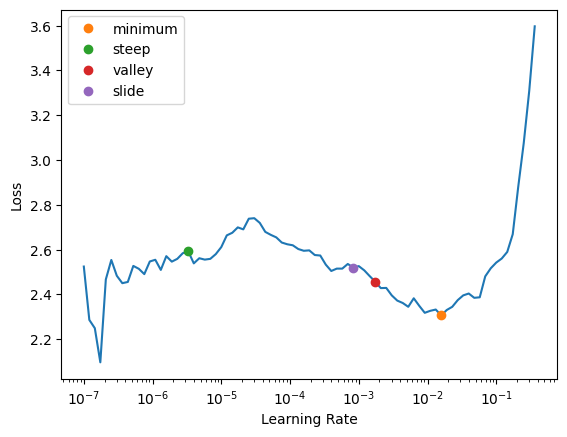

In [9]:
lrs_128 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'learning rate optimal: {lrs_128.minimum, lrs_128.steep, lrs_128.valley, lrs_128.slide}')

In [10]:
learn.fit_one_cycle(
    10, 
    lrs_128.valley,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,2.001774,1.217512,0.474872,03:02
1,1.701806,1.091318,0.536216,03:05
2,1.373082,1.077628,0.582871,03:04
3,1.244299,0.940551,0.622362,03:03
4,1.171673,0.873066,0.684452,03:05
5,1.114451,0.843957,0.654793,03:08
6,0.981901,0.811009,0.734395,03:04
7,0.989049,0.812543,0.703400,03:05
8,0.954805,0.768618,0.741330,03:04
9,0.917936,1.435994,0.722295,03:02


Better model found at epoch 0 with f1_score value: 0.47487189520488704.
Better model found at epoch 1 with f1_score value: 0.53621579316238.
Better model found at epoch 2 with f1_score value: 0.5828709770988632.
Better model found at epoch 3 with f1_score value: 0.6223623266571304.
Better model found at epoch 4 with f1_score value: 0.6844516419253261.
Better model found at epoch 6 with f1_score value: 0.7343951084844523.
Better model found at epoch 8 with f1_score value: 0.7413298594289929.


In [11]:
torch.cuda.empty_cache()
gc.collect()

14779

learning rate optimal: (0.00020892962347716094, 1.9054607491852948e-06, 0.0003311311302240938, 0.00363078061491251)


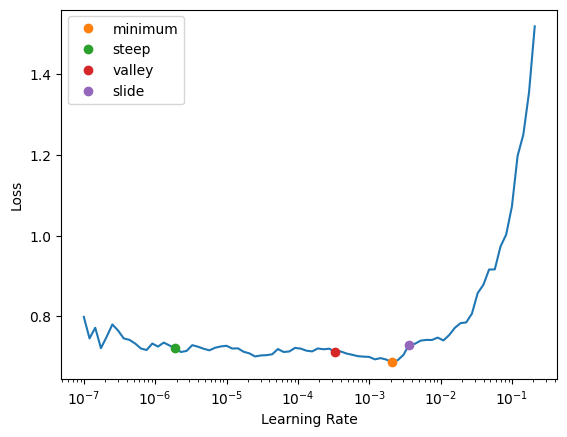

In [12]:
learn.dls = dls_224
lrs_224 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'learning rate optimal: {lrs_224.minimum, lrs_224.steep, lrs_224.valley, lrs_224.slide}')

In [13]:
learn.unfreeze()

learn.fit_one_cycle(
    40,
    lrs_224.minimum/10,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,0.940892,0.765102,0.699824,03:28
1,0.932103,0.779492,0.726593,03:26
2,0.946248,0.764400,0.740500,03:27
3,0.945285,0.749393,0.739630,03:27
4,0.922262,0.766118,0.739921,03:25
5,0.923550,0.744524,0.729786,03:26
6,0.919211,0.726557,0.767140,03:23
7,0.901455,0.726270,0.769662,03:28
8,0.902843,0.714008,0.788622,03:25
9,0.897654,0.723436,0.781970,03:23


Better model found at epoch 0 with f1_score value: 0.6998238530137322.
Better model found at epoch 1 with f1_score value: 0.7265930726247182.
Better model found at epoch 2 with f1_score value: 0.7405003096504155.
Better model found at epoch 6 with f1_score value: 0.7671397884548048.
Better model found at epoch 7 with f1_score value: 0.7696615986748029.
Better model found at epoch 8 with f1_score value: 0.7886217329864987.
Better model found at epoch 10 with f1_score value: 0.8212811132682883.
Better model found at epoch 14 with f1_score value: 0.8353476024841389.


In [14]:
torch.cuda.empty_cache()
gc.collect()

15015

learning rate optimal: (3.981071586167673e-07, 9.12010818865383e-07, 0.00013182566908653826, 0.00015848931798245758)


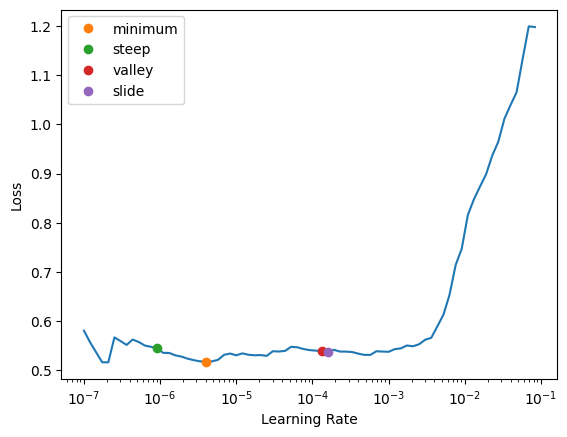

In [15]:
learn.dls = dls_300
lrs_300 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'learning rate optimal: {lrs_300.minimum, lrs_300.steep, lrs_300.valley, lrs_300.slide}')

In [16]:
learn.unfreeze()

learn.fit_one_cycle(
    20,
    lrs_300.minimum/10,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,0.863421,0.670862,0.798189,03:01
1,0.843378,0.678131,0.781236,03:00
2,0.823619,0.694009,0.756561,02:58
3,0.838192,0.679069,0.813820,02:58
4,0.827530,0.690254,0.809172,03:00
5,0.851943,0.678675,0.739978,02:58
6,0.832926,0.672592,0.801001,03:01
7,0.847064,0.685853,0.776406,02:59
8,0.820424,0.693392,0.794569,02:59
9,0.845823,0.667574,0.803915,03:00


Better model found at epoch 0 with f1_score value: 0.798188570050639.
Better model found at epoch 3 with f1_score value: 0.8138201718047237.
Better model found at epoch 15 with f1_score value: 0.8279031035406546.


In [17]:
torch.cuda.empty_cache()
gc.collect()

15802

              precision    recall  f1-score   support

    balinese       0.86      0.98      0.92       136
       batak       0.86      0.75      0.80        16
       dayak       1.00      0.53      0.70        15
    javanese       0.86      0.80      0.83        46
 minangkabau       0.92      0.87      0.90       127

    accuracy                           0.89       340
   macro avg       0.90      0.79      0.83       340
weighted avg       0.89      0.89      0.88       340



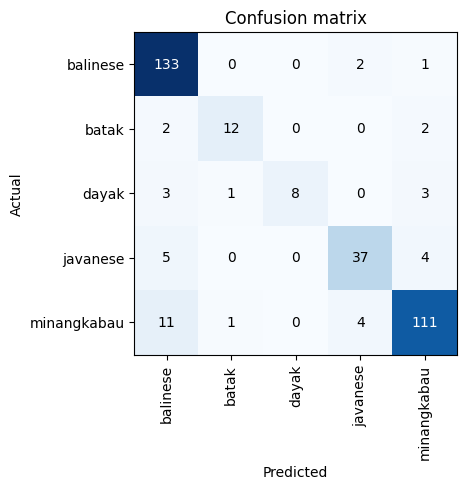

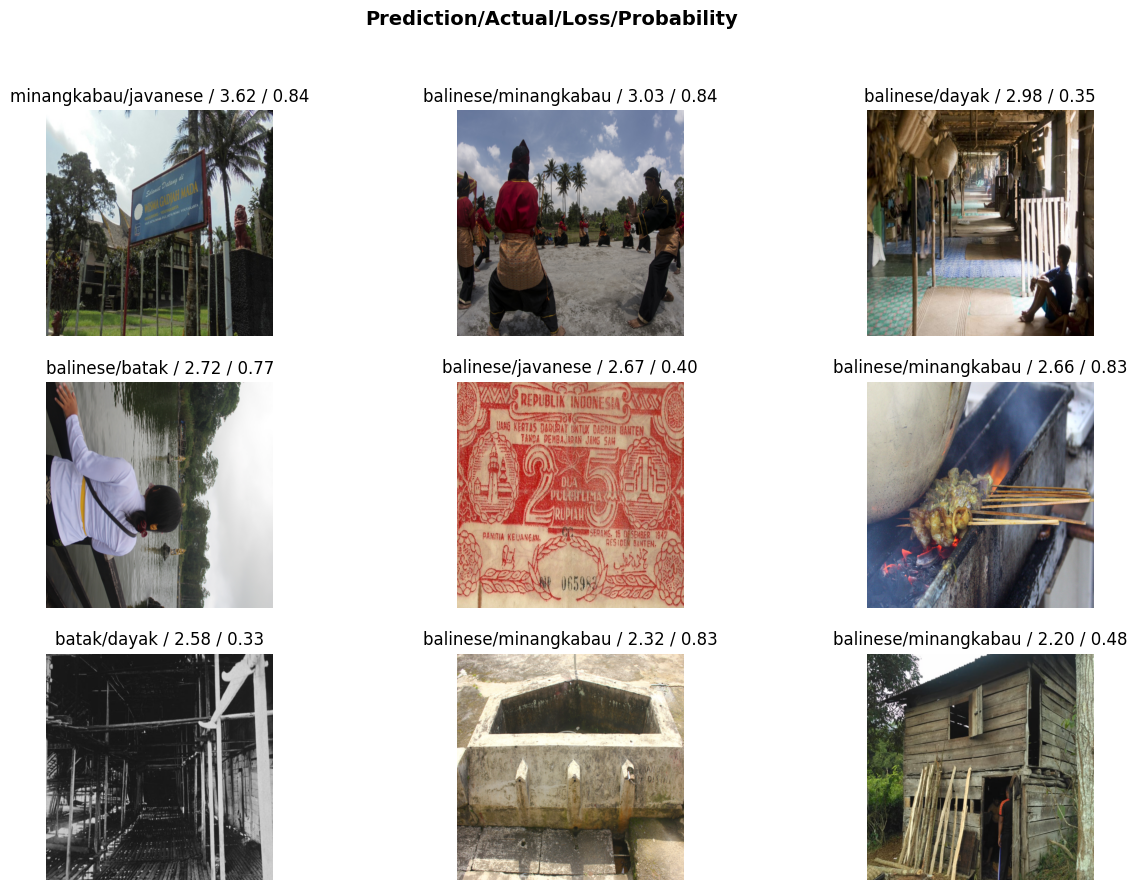

In [18]:
try: 
    interp = ClassificationInterpretation.from_learner(learn, )
    interp.plot_confusion_matrix()
    interp.plot_top_losses(9, figsize=(15,10))
    interp.print_classification_report()
except (AttributeError, NameError) as e:
    print(e)
    pass

In [19]:
nama_file_model = 'klasifikasi-rumah-adat-v1.pkl'
learn.export(nama_file_model)

print(f"Model berhasil disimpan sebagai '{nama_file_model}'!")

Model berhasil disimpan sebagai 'klasifikasi-rumah-adat-v1.pkl'!


In [20]:
test_files = get_image_files(test_path)
preds, _ = learn.get_preds(dl=dls_224.test_dl(test_files))
pred_labels = preds.argmax(dim=1)
label_names = [dls_224.vocab[i] for i in pred_labels]

In [21]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_get_preds = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_get_preds = submission_get_preds.set_index('id').loc[sample_sub['id']].reset_index()

submission_get_preds.sort_values('id', inplace = True)
submission_get_preds['style'].value_counts()

style
balinese       215
minangkabau    133
javanese        66
batak           21
dayak            9
Name: count, dtype: int64

In [22]:
# Save to CSV
submission_get_preds.to_csv('submission_get_preds.csv', index=False)
print("Submission file saved as submission_get_preds.csv")

Submission file saved as submission_get_preds.csv


In [23]:
test_dl = dls_224.test_dl(test_files)
preds, _ = learn.tta(dl=test_dl)
pred_labels = preds.argmax(dim=1)
label_names = [dls_224.vocab[i] for i in pred_labels]

In [24]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_tta = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_tta = submission_tta.set_index('id').loc[sample_sub['id']].reset_index()

submission_tta.sort_values('id', inplace = True)
submission_tta['style'].value_counts()

style
balinese       217
minangkabau    131
javanese        65
batak           21
dayak           10
Name: count, dtype: int64

In [25]:
# Save to CSV
submission_tta.to_csv('submission_tta.csv', index=False)
print("Submission file saved as submission_tta.csv")

Submission file saved as submission_tta.csv
